<a href="https://colab.research.google.com/github/l-gorman/cnn_workshop/blob/master/Tensorflow_CNN_TransferLearn_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: working with convolutional neural networks – a hands-on workshop
# Tutorial II: Introduction to Transfer Learning with Convolutional Neural Networks with Tensorflow and Keras

### Chanuki Seresinhe and Stephen Law

If you would prefer to run this code on your own laptop as a Jupyter Notebook, here are instructions on how to install Tensorflow 2: https://www.tensorflow.org/install and Jupyter: https://jupyter.org/install

However, you can run this code here on Google Colab and also access a GPU. If you haven't worked on Google Colab before here are some tips including how to get your Colab Notebook to connect to a GPU https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c

**Okay, let's get started**

In this tutorial we talk you through training a neural network using transfer learning – where you use a pre-trained model as the starting point to train a new model for a different task. There are two ways you can do transfer learning: feature extraction and fine-tuning.

When performing feature extraction, we treat the pre-trained network as an arbitrary feature extractor, allowing the input image to propagate forward, and then taking the output of the final layer or one of the last fully connected layers as our features.

With fine-tuning, we also use a pre-trained network, but this time, we allow the network to keep learning from a specified layer while the learned weights from the pre-trained network are set as the initial parameters.

In [0]:
%tensorflow_version 2.x
import random
import os
import json
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, precision_score, recall_score 
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Using TensorFlow Version: {}".format(tf.__version__))
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

TensorFlow 2.x selected.
Using TensorFlow Version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


## First, download the data 

We are going to be using images rated from the website Scenic-Or-Not http://scenicornot.datasciencelab.co.uk/, as was used in this paper to train a neural network to rate the beauty of outdoor places: Seresinhe, C. I., Preis, T., & Moat, H. S. (2017). Using Deep Learning to Quantify the Beauty of Outdoor Places. Royal Society Open Science, 4, 170170. https://royalsocietypublishing.org/doi/full/10.1098/rsos.170170 For ease, we have relabelled a section of these images as "high" and "low" scenic for this tutorial.

In [0]:
 import zipfile
 if not os.path.isfile("scenic_data.zip"):
   !wget "http://www.thoughtsymmetry.com/Turing-CNN-Workshop/scenic_data.zip" \
    -O scenic_data.zip
   !unzip scenic_data.zip
os.listdir("scenic_data")



['train', 'test']

## Set up the parameters for training

In [0]:
img_width = 128
img_height = 128
epochs = 5
batch_size = 32
optimiser = "SGD"
optimiser_params = "{\"lr\": 0.0001}"
finetune = True
model_name = "VGG16"
model_layer = "block3_conv1"
debug = True

## Set up the Image Generators
Generate tensor image data with real-time data augmentation. See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
validation_datagen = ImageDataGenerator(
        rescale=1. / 255)

## Flow training images in batches 
In this example, we flow in data from our image directory where the folders contain the labels of the images using the newly created Image Generators

In [0]:

train_generator = train_datagen.flow_from_directory(
        'scenic_data/train/',  # This is the source directory for training images
        target_size=(img_height, img_width),  # All images will be resized to the image width and height set above
        batch_size=batch_size, # Training is done 
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(
        'scenic_data/test/',  # This is the source directory for training images
        target_size=(img_height, img_width),  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 751 images belonging to 2 classes.


## Before training our model, let's take a look at this dataset
This time we are grabbing images that have been augmented with the Image Generator so you will see that they look a bit distorted as they have been flipped, shifted and/or rotated. This ensures that the model can learn to predict on a wider variety of images, which will help it generalise to new images the network has not seen before.



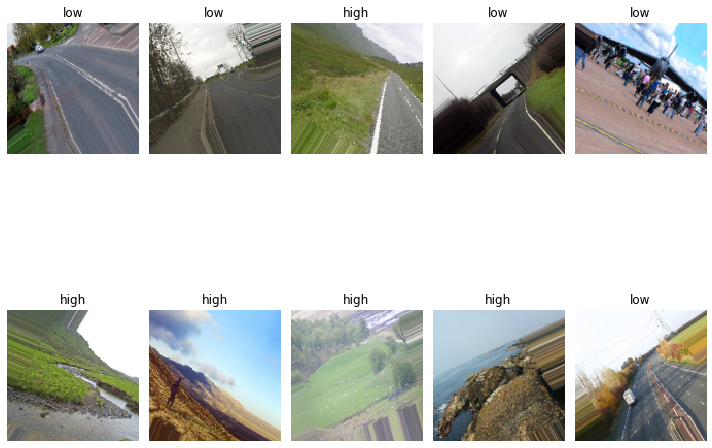

In [0]:
sample_training_images, labels = next(train_generator)
label_names = ['high','low']


def plotImages(images_arr, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax, label in zip(images_arr, axes, labels):
        ax.imshow(img)
        ax.set_title(label_names[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10], labels[:10])

## Let's set up some functions to help manipulate the CNN architecture for transfer learning:

In [0]:
def check_valid_model_layer(base_model, model_layer):
    """
    Check to see if model layer name matches a layer in the chosen model
    """
    valid_layers = [layer.name for layer in base_model.layers]
    assert model_layer in valid_layers, "{} is an invalid layer. Acceptable layers include {}".format(model_layer,
        valid_layers)
    

def freeze_layers(base_model, model_layer):
    """
    Freeze all layers up to a specific one for ImageNet or similar pretrained models
    """
    base_model.trainable = True
    set_trainable = False

    for layer in base_model.layers:
        if layer.name == model_layer:
            set_trainable = True
        layer.trainable = set_trainable

    print("Layers being trained:")
    for i, layer in enumerate(base_model.layers):
        print("{} {} {}".format(i, layer.name, layer.trainable))

    return base_model    

## We now load a pre-trained model and choose whether we want to perform Fine Tuning or Feature Extraction

In [0]:
print('Loading weights from {} ImageNet model'.format(model_name))
model_class = getattr(tf.keras.applications, model_name)
base_model = model_class(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    
if finetune:
  print("Fine Tuning")
  check_valid_model_layer(base_model, model_layer)
  # When we choose to fine tune out network, we allow the network to start learning
  base_model = freeze_layers(base_model, model_layer)
else:
  # We don't allow the model to learn any new weights on the pre-trained model. 
  # Rather, we simply take the outputs of the final layer as our features.
  print("Feature Extracting") 

Loading weights from VGG16 ImageNet model
Fine Tuning
Layers being trained:
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


## We set the new model with a few more Fully Connected layers including a final layer for our binary "high" or "low" output

In [0]:
new_model = models.Sequential()
new_model.add(base_model)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(256, activation='relu'))
new_model.add(layers.Dense(1, activation='sigmoid'))

print("Model summary:")
new_model.summary()

Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,552,193
Non-trainable params: 260,160
_________________________________________________________________


## Finally, we set up the optmiser and train our model

In [0]:
# Set up the optimizer
optimiser_function = getattr(optimizers, optimiser)
kwargs = json.loads(optimiser_params)
optimiser_function = optimiser_function(**kwargs)
new_model.compile(optimiser_function, loss="binary_crossentropy", metrics=["accuracy"])
print("Optimising using {}".format(optimiser))

# Run the model and store the results in history
training_steps =  math.ceil(train_generator.n/ batch_size)
validation_steps = math.ceil(validation_generator.n/ batch_size) 

history = new_model.fit(
        train_generator,
        steps_per_epoch=training_steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        shuffle=False,
        workers=12,
    )

Optimising using SGD
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 94 steps, validate for 24 steps
Epoch 1/5
94/94 [==============================] - 36s 380ms/step - loss: 0.6971 - accuracy: 0.5430 - val_loss: 0.6247 - val_accuracy: 0.6525
Epoch 2/5
94/94 [==============================] - 32s 337ms/step - loss: 0.6058 - accuracy: 0.7303 - val_loss: 0.5468 - val_accuracy: 0.8162
Epoch 3/5
94/94 [==============================] - 31s 335ms/step - loss: 0.5313 - accuracy: 0.8377 - val_loss: 0.4674 - val_accuracy: 0.8695
Epoch 4/5
94/94 [==============================] - 32s 341ms/step - loss: 0.4553 - accuracy: 0.8840 - val_loss: 0.3870 - val_accuracy: 0.9121
Epoch 5/5
94/94 [==============================] - 32s 337ms/step - loss: 0.3743 - accuracy: 0.9040 - val_loss: 0.3169 - val_accuracy: 0.9134


## Plot the training loss and accuracy

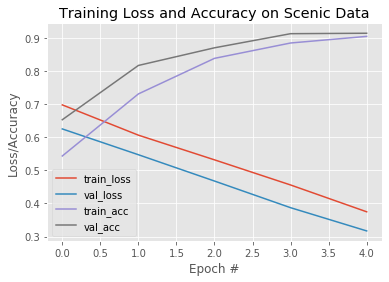

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Scenic Data")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("sequential.png")

## Plot the predictions 


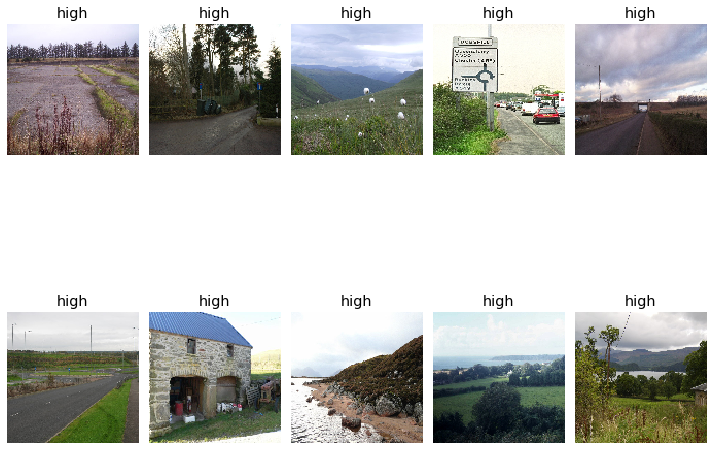

In [0]:
sample_test_images, labels = next(validation_generator)

def load_image(image):

    img = image.astype('float32')
    img_tensor = np.expand_dims(img, axis=0)                       
    return img_tensor


def plotImages(images_arr, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax, label in zip(images_arr, axes, labels):
        ax.imshow(img)
        img_tensor= load_image(img)
        prediction = new_model.predict(img_tensor, batch_size=1)[0].round()
        prediction_name = label_names[prediction.argmax()]
        label_name = label_names[label.argmax()]
        ax.axis('off')
        if label_name == prediction_name:
          ax.set_title(prediction_name)
        else:
          ax.set_title("{} NOT {}".format(label_name,prediction_name))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_test_images[:10], labels[:10])

## Finally, save your model



You can reload your model later using : 

```
from tensorflow.keras.models import load_model
scenic_model = load_model("scenic_model.h5")
```



In [0]:
new_model.save("scenic_model.h5")

### 7. Exercise for class
Try to change some of the following to improve the accuracy.

* Change optimizer to ADAM or NADAM. See https://www.tensorflow.org/api_docs/python/tf/keras/optimizers 
* Change epochs 
* Change learning rate 
* Change batch size
* Change the metric in Tensorflow from accuracy to precision instead. See https://www.tensorflow.org/api_docs/python/tf/keras/metrics/
* Try different deep learning architectures with pre-trained weights other than VGG. See https://www.tensorflow.org/api_docs/python/tf/keras/applications

Finally, load in a different dataset as a CSV and try using flow from dataframe. See initial steps below. Note that this dataset is a multicategory (NOT binary) dataset, so there will be a few things you need to change. 





## The Popsa Dataset
In this exercise, we are going to be using data from Popsa.com (where Chanuki Seresinhe works as the Lead Data Scientist). At Popsa, we use AI to automatically curate people's photos into beautifully designed photobooks. When we detect a set of photos that might make a good photobook, we first need to understand what kind of story it is. Therefore, we need to analyse the content of the photos to determine what type of typical photobook story it is.

The images in this dataset have been downloaded using the Flickr API (https://www.flickr.com/services/api/) and are available for public use. In fact, this is a great resource for labelled data, although you will still need to label the data yourself if you want completely accurate labels as the text metadata doesn’t always match correctly with the actual content of the images.

These images have been verified by Popsa to either be "Birthday Party" (167 photos), "Ski Holiday" (295 photos), "Wedding" (256 photos) or "Other" (659 photos). Normally, you would need a few thousand images per category to train a neural network to recognise quite varied categories, so this sample dataset is just for tutorial purposes only.

This dataset has been split into a train (60%), val (20%), test (20%), eyeball (10% of val). 

What is an eyeball set for? In Machine Learning Yearning (https://www.deeplearning.ai/content/uploads/2018/09/Ng-MLY01-12.pdf), Andrew Ng suggests that one should randomly select 10% of the dev set and place that into what we’ll call an Eyeball dev set​ to remind ourselves that we are looking at it with our eyes. If performance on the Eyeball dev becomes much better than the Blackbox dev set, you then know that you have now overfit the Eyeball dev set and should consider acquiring more data for it.

In [0]:
import pandas as pd
if not os.path.isfile("Popsa_Flickr_Data.zip"):
   !wget "http://www.thoughtsymmetry.com/Turing-CNN-Workshop/Popsa_Flickr_Data.zip" \
    -O Popsa_Flickr_Data.zip
   !unzip Popsa_Flickr_Data.zip
os.listdir("Popsa_Flickr_Data")

train_df = pd.read_csv('Popsa_Flickr_Data/train.csv')
val_df = pd.read_csv('Popsa_Flickr_Data/val.csv')
test_df = pd.read_csv('Popsa_Flickr_Data/test.csv')
eyeball_df = pd.read_csv('Popsa_Flickr_Data/eyeball.csv')
img_dir = 'Popsa_Flickr_Data/images'
train_df.head()




,filename,label
0,47710107311_01414bac81_z.jpg,Wedding
1,420837006_1ec8bda762_z.jpg,Ski holiday
2,25306318531_03ff85aab7_z.jpg,Wedding
3,26578686542_6652f4dd89_z.jpg,Ski holiday
4,48091849421_12446b2702_z.jpg,Ski holiday
